In [18]:
'''
Python utilities for HMOG dataset
Five functions are implemented here:
 1) overSampling(): For touch gesture samples, because the length of touch gesture logs is small compared to sensor logs.
 
    - overSampling() function is used for replicating touch gesture samples using the concept of *oversampling*. 
    - Motion and touch data don't have the same length across different sessions and users.
 2) ETLHelper(): ETL stands for: Extract Transform and Load.
 3) ETL().
 4) dataGenerator()
 5) slice(): For slicing the data in an overlapping fashion. 
'''
# split a dataset into train and test sets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split

import numpy as np

from sklearn.preprocessing import StandardScaler


'''
overSampling():

A) Parameters:
- touchData: numpy array of touchscreen data extracted from csv files.
- maxLength: integer which denotes the maximum length wanted for the touchData.
- touchData must have the same length as sensor data. 

B) Output:
-  Returns a new touchData array with the same length as sensorData array

C) overSampling uses two methods from random module:
- 1) random.choices(): to generate random list from a given sequence of indices
random.choices() is used if the number of indices >= length of touchData

ex: 
- missignList = random.choices([0, 1, 2], k = 20), here the given list has 3 elements and indices=20
- Length of the list=3 can be less than the number of indices=20. 

- 2) random.sample(): to generate random list from a given sequence of indices
random.sample() is used only if the number of indices < length of touchData

ex:
- missingList = random.sample(range(0,10), 10), given sequence has 10 elements, inidces can be <=10. 
'''
from tensorflow.keras.models import Sequential, load_model


def overSampling(touchData, maxLength):

    missingValues = maxLength - len(touchData)
    if missingValues >= len(touchData):

        touchList = list(range(len(touchData)))
        # missingIndices : generated random indices in range: touchList with max values = missingValues
        missingIndices = random.choices(touchList, k=missingValues) 
        missingData = []
        for i in range(len(missingIndices)):
            missingData.append(touchData[missingIndices[i],:])

        missingData = np.array(missingData)
        touchArray = np.vstack([touchData, missingData])
    else:
        # if the length of the missing values is < to the length of touchData 
        # we use random.sample()
        
        missingIndices = random.sample(range(0,missingValues), missingValues)
        missingData = touchData[missingIndices,:]
        touchArray = np.vstack([touchData, missingData])
        
    return touchArray

"""
ETLHelper takes an input, ex: userPath=0 (userId between 0 and 99), and a session ex: sessionPath=0. 
ETL Helper reads out the sensor csv files with numpy.genfromtxt() function and stack horizontally the files and returns the result
"""


def ETLHelper(userID, sessionPath):
    # define the current working directory
    home = os.getcwd()

    userPath =  home + '/' + str(userID) +'/'
    sessionPath = str(sessionPath) + '/'
    path = Path(userPath, sessionPath)

    os.chdir(path)

    # Load sensor data (acc, gyr, mag)
    acc = np.genfromtxt('Accelerometer.csv', delimiter=',')[:10000,3:6]
    gyr = np.genfromtxt('Gyroscope.csv', delimiter=',')[:10000,3:6]
    mag = np.genfromtxt('Magnetometer.csv', delimiter=',')[:10000,3:6]
    # Compute the norm for each sensor
    acc_norm = np.sqrt((acc[:,0])**2 + (acc[:,1])**2 + (acc[:,2])**2)
    gyr_norm = np.sqrt((gyr[:,0])**2 + (gyr[:,1])**2 + (gyr[:,2])**2)
    mag_norm = np.sqrt((mag[:,0])**2 + (mag[:,1])**2 + (mag[:,2])**2)
    
    # Add a dimension for each sensor: (nrow_, 1 column)
    acc_norm = np.expand_dims(acc_norm, axis=1)
    gyr_norm = np.expand_dims(gyr_norm, axis=1)
    mag_norm = np.expand_dims(mag_norm, axis=1)
    sensorStack = np.hstack([acc_norm, gyr_norm, mag_norm])

    # load touch gesture data
    touchActivity = np.genfromtxt('TouchEvent.csv', delimiter=',')[:10000,[6,7,8,9]]
    if len(touchActivity) < 10000:
        touchActivity = overSampling(touchData=touchActivity, maxLength=10000)

    os.chdir(home)
    
    return sensorStack, touchActivity


"""
ETL() takes a user target ID with and a session list : [].
Using the ETLHelper(), the ETL() function loops through the sessions and returns (or yield) the data by stacking each session vertically.
"""

def ETL(user, session):
    sessionSetSensor = []
    sessionSetTouch = []

    for i in tqdm(range(len(session))):
        s, t =  ETLHelper(userID=user, sessionPath=session[i])
        
        sessionSetSensor.append(s) # append all sensor data
        sessionSetTouch.append(t)  # append all touch data


    sessionSetSensor = np.vstack(sessionSetSensor)
    sessionSetTouch = np.vstack(sessionSetTouch)

    # userLabel = user
    userLabel = np.zeros(sessionSetSensor.shape[0]) + user    #Labeling all the data is required
    yield sessionSetSensor, sessionSetTouch, userLabel


''' 
dataGenerator()
Generate:
- sensorData
- TouchData
- Labels
Append them in a list and stack them

A) Parameters:
- 1) users: Integer value between [0, 99].
- 2) session: Integer value between [0,23].

B) Output:
- 1) sensor: numpy array of sensor logs
- 2) touch: numpy array of touch logs
- 3) labels: ground truth labels for each user. 

'''

def dataGenerator(numUsers, session):
    sensorData = []
    touchData = []
    y = []
    u = 0
    while u <= numUsers:
        print("User ID: ", u)
        for sensor, touch, labels in ETL(user=u, session=range(session)):
            
            print("shape of input sensor", sensor.shape)
            print("shape of touch data", touch.shape)
            print("Shape of labels", labels.shape)
            sensorData.append(sensor)
            touchData.append(touch)
            y.append(labels)
            u +=1

    sensorArray = np.vstack(sensorData)
    touchArray = np.vstack(touchData)
    labelArray = np.hstack(y) 
    # hstack because y is returned in a columnwise fashion
    labelArray = np.expand_dims(labelArray, axis=1)
    sensor_scaler = StandardScaler()
    touch_scaler = StandardScaler()
    sensorScaler = sensor_scaler.fit(sensorArray)
    touchScaler = touch_scaler.fit(touchArray)

    sensorNormalized = sensorScaler.transform(sensorArray)
    touchNormalized = touchScaler.transform(touchArray)

    return sensorNormalized, touchNormalized, labelArray


'''
Implement the slice() fucntion:
A ) Parameters:
- data: input array --> input type: numpy array

- window_length: length of the slicing window --> input type integer

- overlapping: the percentage of overlapping --> input type float [0,1]
'''

def slice(data, window_length, overlapping):
    length_data = len(data)

    number_slices = int(np.floor((length_data - window_length)/(window_length*(1 - overlapping)))+1)

    slices = []
    for i in range(number_slices):

        start = int(i * window_length * (1-overlapping))

        end = start + window_length

        slices.append(data[start:end,:])

    slice_samples = np.array(slices)
    
    
    return slice_samples


def split_datasety(dataset, chunk_size):
    num_chunks = dataset.shape[0] // chunk_size
    chunks = []
    for i in range(0,num_chunks):
            start = i*chunk_size
            end = start + chunk_size
            chunk = dataset[end-1:end, :]
            chunks.append(chunk)
    return np.array(chunks)


In [19]:
x,u,z=dataGenerator(3,13)

User ID:  0


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:14<00:00,  1.09s/it]


shape of input sensor (130000, 3)
shape of touch data (130000, 4)
Shape of labels (130000,)
User ID:  1


100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


shape of input sensor (130000, 3)
shape of touch data (130000, 4)
Shape of labels (130000,)
User ID:  2


100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


shape of input sensor (130000, 3)
shape of touch data (130000, 4)
Shape of labels (130000,)
User ID:  3


100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


shape of input sensor (130000, 3)
shape of touch data (130000, 4)
Shape of labels (130000,)


In [20]:
x_train=slice(x, 500, 0)
y_train=split_datasety(z, 500)

In [21]:
print(x_train.shape)
print(y_train.shape)


(1040, 500, 3)
(1040, 1, 1)


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.15,shuffle=True)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2,shuffle=True)

In [82]:
print(X_test.shape)
print(Y_test.shape)

print(X_valid.shape)
print(Y_valid.shape)

(208, 500, 3)
(208, 1, 1)
(208, 500, 3)
(208, 1, 1)


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt   #matplotlib
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import TimeDistributed
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from sklearn.metrics import classification_report
from keras.layers import Permute, Reshape
from sklearn import metrics
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint
from sklearn.linear_model import LogisticRegression
from scipy import stats
from keras.preprocessing.sequence import TimeseriesGenerator
from numpy import array
from numpy import hstack
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv1D,Conv2D, ReLU, BatchNormalization, MaxPooling1D,MaxPool2D, Concatenate, GRU, GlobalAveragePooling1D, Dense ,LSTM


In [23]:
input_shape = (500,3)
# Channel 1
input_channel1 = Input(shape=input_shape)
conv1_channel1 = Conv1D(filters = 64,  kernel_size=5,padding = 'same',activation='relu', input_shape=input_shape,kernel_regularizer =tf.keras.regularizers.l2(l2=0.03))(input_channel1)
batch_norm1_channel1 = BatchNormalization()(conv1_channel1)
conv2_channel1 = Conv1D(filters = 128, kernel_size=5, activation='relu',kernel_regularizer =tf.keras.regularizers.l2(l2=0.01))(batch_norm1_channel1)
max_pooling_channel1 = MaxPooling1D(pool_size=2)(conv2_channel1)

# Channel 2
input_channel2 = Input(shape=input_shape)
conv1_channel2 = Conv1D(filters = 64,  kernel_size=5,padding = 'same',activation='relu', input_shape=input_shape,kernel_regularizer =tf.keras.regularizers.l2(l2=0.03))(input_channel2)
batch_norm1_channel2 = BatchNormalization()(conv1_channel2)
conv2_channel2 = Conv1D(filters = 128, kernel_size=5, activation='relu',kernel_regularizer =tf.keras.regularizers.l2(l2=0.03))(batch_norm1_channel2)
max_pooling_channel2 = MaxPooling1D(pool_size=2)(conv2_channel2)

# Channel 3
input_channel3 = Input(shape=input_shape)
conv1_channel3 = Conv1D(filters = 64,  kernel_size=7,padding = 'same',activation='relu', input_shape=input_shape,kernel_regularizer =tf.keras.regularizers.l2(l2=0.03))(input_channel3)
batch_norm1_channel3 = BatchNormalization()(conv1_channel3)
conv2_channel3 = Conv1D(filters = 128, kernel_size=7, activation='relu',kernel_regularizer =tf.keras.regularizers.l2(l2=0.03))(batch_norm1_channel3)
max_pooling_channel3 = MaxPooling1D(pool_size=2)(conv2_channel3)

concatenated_features = Concatenate(axis=1)([max_pooling_channel1])

# GRU layer
gru = GRU(80, return_sequences=True,dropout=0.2)(concatenated_features)
gru1 = GRU(40, return_sequences=True,dropout=0.2)(gru)

# Global Average Pooling
gap = GlobalAveragePooling1D()(gru1)

# Batch Normalization
batch_norm2 = BatchNormalization()(gap)

# Batch Normalization

output = Dense(4,activation='softmax')(batch_norm2)

# Create the model
model = Model(inputs=[(input_channel1)], outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500, 3)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 500, 64)           1024      
                                                                 
 batch_normalization_4 (Batc  (None, 500, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 496, 128)          41088     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 248, 128)         0         
 1D)                                                             
                                                                 
 concatenate_1 (Concatenate)  (None, 248, 128)         0   

In [24]:

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
cp = ModelCheckpoint("C:/Users/Nouveau dossier (2)/hmog/Data_1/saved_model/best_checkpoint22.hdf5", monitor = 'val_accuracy', save_best_only = True, verbose = 1)

h=model.fit([X_train],Y_train,validation_data =([X_valid],Y_valid) , epochs=50, callbacks = [cp], workers = 32)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.6960 - accuracy: 0.7511
Epoch 1: val_accuracy improved from -inf to 0.58757, saving model to C:/Users/Nouveau dossier (2)/hmog/Data_1/saved_model\best_checkpoint22.hdf5
23/23 [==============================] - 25s 559ms/step - loss: 1.6960 - accuracy: 0.7511 - val_loss: 2.1391 - val_accuracy: 0.5876
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.3512 - accuracy: 0.8529
Epoch 2: val_accuracy improved from 0.58757 to 0.66102, saving model to C:/Users/Nouveau dossier (2)/hmog/Data_1/saved_model\best_checkpoint22.hdf5
23/23 [==============================] - 10s 417ms/step - loss: 1.3512 - accuracy: 0.8529 - val_loss: 1.9833 - val_accuracy: 0.6610
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.2544 - accuracy: 0.8416
Epoch 3: val_accuracy did not improve from 0.66102
23/23 [==============================] - 9s 407ms/step - loss: 1.2544 - accuracy: 0.8416 - val_loss: 1.8434 - 

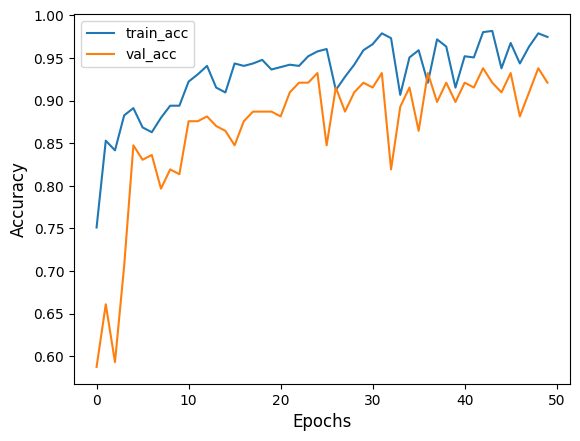

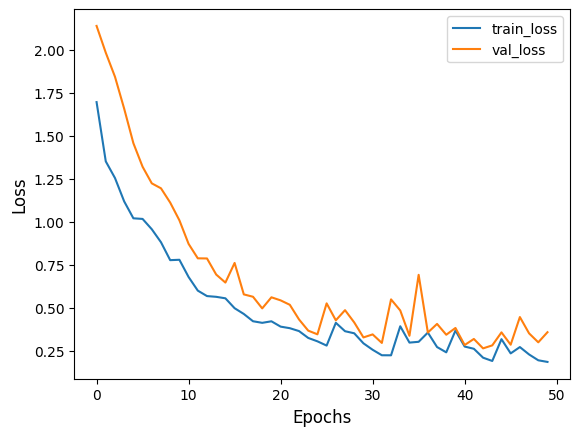

In [25]:

plt.plot(h.history["accuracy"], label = "train_acc")
plt.plot(h.history["val_accuracy"], label = "val_acc")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.legend()
plt.show()
plt.plot(h.history["loss"], label = "train_loss")
plt.plot(h.history["val_loss"], label = "val_loss")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()

plt.show()

In [27]:
model.evaluate(X_test, Y_test)

5/5 [==============================] - 2s 83ms/step - loss: 0.3477 - accuracy: 0.9295


[0.3477322459220886, 0.9294871687889099]

In [37]:
l=155
print("ground truth is :", Y_test[l])
yhat = model.predict(X_test)
print("predicted persson is :", yhat[l])

ground truth is : [[3.]]
5/5 [==============================] - 0s 78ms/step
predicted persson is : [7.4901429e-05 1.2674605e-04 1.9332876e-06 9.9979645e-01]
